/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


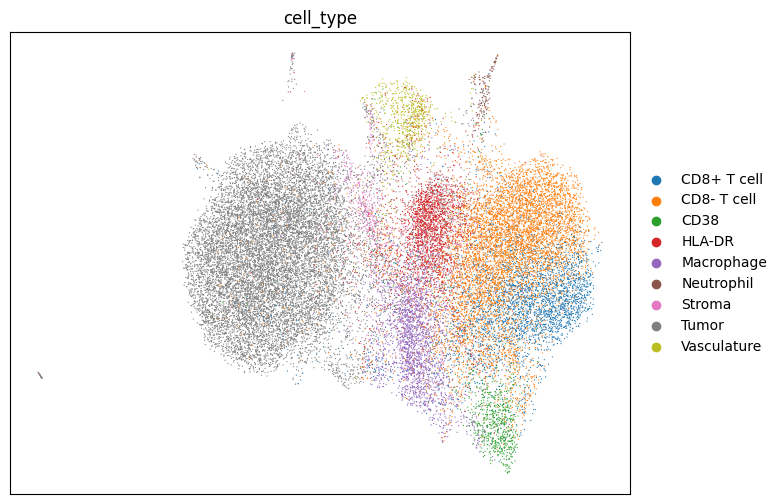

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import pandas as pd
import scanpy as sc

np.random.seed(42)

def generate_imbalanced_data(proportions, centers, cluster_std=0.5, random_state=42):
    total_samples = sum(proportions) * 1000
    n_samples = [int(total_samples * p / sum(proportions)) for p in proportions]
    
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, y

def visualize(X, y, centers=None):
    """
    Visualize data points with optional cluster centers using t-SNE.

    Parameters:
    - X: (array-like) Data points.
    - y: (array-like) Cluster labels for each data point.
    - centers: (array-like) Optional cluster centers.

    Returns:
    None
    """
    # Create a fixed colormap for up to 10 clusters
    cmap = ListedColormap([
        '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', 
        '#a65628', '#984ea3', '#999999', 
        '#dede00', '#66c2a5', '#fc8d62'
    ])

    unique_labels = np.unique(y)

    if len(unique_labels) <= 10:
        cmap = ListedColormap([
            '#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
            '#a65628', '#984ea3', '#999999', 
            '#dede00', '#66c2a5', '#fc8d62'
        ])
    else:
        cmap = plt.cm.tab20 

    # Prepare combined data for t-SNE transformation
    if centers is not None:
        combined = np.vstack([X, centers])
    else:
        combined = X

    tsne = TSNE(n_components=2, random_state=42)
    combined_tsne = tsne.fit_transform(combined)

    X_tsne = combined_tsne[:len(X)]
    centers_tsne = combined_tsne[len(X):] if centers is not None else None

    plt.figure(figsize=(8, 6))

    # Plot data points with fixed colormap
    for i, label in enumerate(unique_labels):
        mask = y == label
        plt.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            c=[cmap(i)],
            label=f'Cluster {label}',
            alpha=0.5,
            s=3
        )

    # Plot cluster centers if provided
    if centers_tsne is not None:
        plt.scatter(
            centers_tsne[:, 0],
            centers_tsne[:, 1],
            c='red',
            marker='X',
            s=50,
            label='Cluster Centers'
        )

    # Create custom legend
    handles = [Patch(color=cmap(i), label=f'Cluster {label}') for i, label in enumerate(unique_labels)]
    handles.append(Patch(color='red', label='Cluster Centers'))
    plt.legend(handles=handles, loc='best')

    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization of Clusters')
    plt.show()


def visualize_umap(feature, cell_type):
    """
    Visualize data using UMAP without axis labels.

    Parameters:
    - feature: (array-like) Input features.
    - cell_type: (array-like) Corresponding cell types.

    Returns:
    None
    """
    adata = sc.AnnData(feature)
    adata.obs['cell_type'] = cell_type

    # Preprocessing and dimensionality reduction
    sc.pp.subsample(adata, fraction=0.1)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    # Plot UMAP
    fig, ax = plt.subplots(figsize=(8, 6))
    sc.pl.umap(adata, color=['cell_type'], size=3, ax=ax, show=False)
    
    # Remove axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.show()

table = pd.read_csv('/home/haiping_liu/code/My_model/ImCluster/data/hoch_berd_embed.csv')
feature = table.iloc[:, 0:20].values
batch_id = table.iloc[:, 20].values
cell_type = table.iloc[:, 21].values

visualize_umap(feature, cell_type)

/root/miniconda3/envs/idea/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI): 0.5066
Normalized Mutual Information (NMI): 0.4987


/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


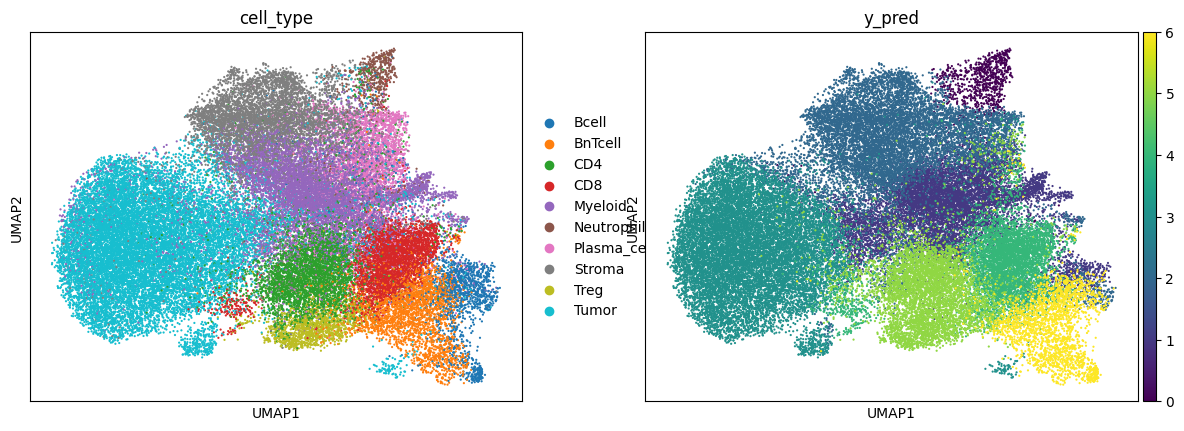

In [2]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(feature)
kmeans_pre = kmeans.labels_
adata.obs['y_pred'] = kmeans_pre

ari = adjusted_rand_score(cell_type, kmeans_pre)
nmi = normalized_mutual_info_score(cell_type, kmeans_pre)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

sc.pl.umap(adata, color=['cell_type', 'y_pred'], size=10)

In [4]:
import torch.nn as nn 
import torch

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, input_dim),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z, out

class DEC(nn.Module):
    def __init__(self, input_dim, latent_dim, n_clusters):
        super(DEC, self).__init__()
        self.autoencoder = Autoencoder(input_dim, latent_dim)
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        
        initial_cluster = torch.zeros(n_clusters, latent_dim, dtype=torch.float)
        self.clusters = nn.Parameter(initial_cluster)
    
    def forward(self, x):
        z, out = self.autoencoder(x)
        q = self.calculate_q(z)
        return q, out
    
    def calculate_q(self, z):
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters) ** 2, dim=2))
        q = q ** ((1 + 1) / 2.0)  
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q
        
    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.t() / weight.sum(1)).t()

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

X_tensor = torch.tensor(feature, dtype=torch.float32)
label_encoder = LabelEncoder()
cell_type = label_encoder.fit_transform(cell_type) 
y_tensor = torch.tensor(cell_type, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = feature.shape[1]
latent_dim = 10
n_clusters = 7
model = DEC(input_dim=input_dim, latent_dim=latent_dim, n_clusters=n_clusters).to(device)

def pretrain_autoencoder(model, data_loader, device, epochs=50, lr=1e-3):
    print("开始预训练自编码器...")
    model.autoencoder.train()
    optimizer = optim.Adam(model.autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_data in tqdm(data_loader, desc=f"预训练 Epoch {epoch+1}/{epochs}"):
            x, _ = batch_data
            x = x.to(device)
            optimizer.zero_grad()
            z, out = model.autoencoder(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        print(f"预训练 Epoch {epoch+1}, 损失: {avg_loss:.4f}")
    print("预训练完成。\n")

def initialize_clusters(model, data_loader, device):
    print("使用K-Means初始化聚类中心...")
    model.autoencoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="提取嵌入特征"):
            x, y = batch_data
            x = x.to(device)
            z, _ = model.autoencoder(x)
            embeddings.append(z.detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels, axis=0) 
    
    kmeans = KMeans(n_clusters=model.n_clusters, init='k-means++', n_init=20, random_state=42)
    y_pred = kmeans.fit_predict(embeddings)
    
    model.clusters.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)
    # visualize(embeddings, labels)
    # visualize(embeddings, y_pred)
    print("聚类中心初始化完成。\n")
    
def train_DEC(model, data_loader, device, epochs=200, lr=1e-3, update_interval=10, tol=1e-3, alpha=0.005):
    print("开始训练DEC模型...")
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 定义损失函数
    criterion_kl = nn.KLDivLoss(reduction='batchmean')
    criterion_recon = nn.MSELoss()
    
    # 记录前一次的验证损失，用于判断收敛
    previous_loss = 0
    
    for epoch in range(epochs):
        total_loss = 0
        total_kl_loss = 0
        total_recon_loss = 0
        for batch_data in tqdm(data_loader, desc=f"DEC训练 Epoch {epoch+1}/{epochs}"):
            x, _ = batch_data
            x = x.to(device)
            
            # 前向传播
            q, x_reconstructed = model(x)  # 假设模型返回q和重建的x
            
            # 计算目标分布
            p = model.target_distribution(q).detach()
            
            # 计算损失
            kl_loss = criterion_kl(torch.log(q), p)
            recon_loss = criterion_recon(x_reconstructed, x)
            loss = kl_loss + alpha * recon_loss
            
            # 反向传播与优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_kl_loss += kl_loss.item()
            total_recon_loss += recon_loss.item()
        
        avg_loss = total_loss / len(data_loader)
        avg_kl_loss = total_kl_loss / len(data_loader)
        avg_recon_loss = total_recon_loss / len(data_loader)
        print(f"Epoch {epoch+1}, 总损失: {avg_loss:.4f}, KL损失: {avg_kl_loss:.4f}, 重建损失: {avg_recon_loss:.4f}")
        
        # 每隔update_interval个epoch检查一次收敛
        if (epoch + 1) % update_interval == 0:
            model.eval()
            total_loss_val = 0
            total_kl_loss_val = 0
            total_recon_loss_val = 0
            with torch.no_grad():
                for batch_data in data_loader:
                    x, _ = batch_data
                    x = x.to(device)
                    q, x_reconstructed = model(x)
                    p = model.target_distribution(q).detach()
                    kl_loss = criterion_kl(torch.log(q), p)
                    recon_loss = criterion_recon(x_reconstructed, x)
                    loss = kl_loss + alpha * recon_loss
                    total_loss_val += loss.item()
                    total_kl_loss_val += kl_loss.item()
                    total_recon_loss_val += recon_loss.item()
            avg_loss_val = total_loss_val / len(data_loader)
            avg_kl_loss_val = total_kl_loss_val / len(data_loader)
            avg_recon_loss_val = total_recon_loss_val / len(data_loader)
            print(f"验证损失: 总损失={avg_loss_val:.4f}, KL损失={avg_kl_loss_val:.4f}, 重建损失={avg_recon_loss_val:.4f}")
            
            # 判断是否收敛
            if np.abs(previous_loss - avg_loss_val) < tol:
                print("收敛判定：训练停止。")
                break
            previous_loss = avg_loss_val
            model.train()
    print("DEC训练完成。\n")

In [6]:
# 预训练自编码器
pretrain_autoencoder(model, data_loader, device, epochs=200, lr=1e-3)

开始预训练自编码器...


预训练 Epoch 1/200: 100%|██████████| 1201/1201 [00:04<00:00, 282.69it/s]


预训练 Epoch 1, 损失: 0.0372


预训练 Epoch 2/200: 100%|██████████| 1201/1201 [00:04<00:00, 298.10it/s]


预训练 Epoch 2, 损失: 0.0172


预训练 Epoch 3/200: 100%|██████████| 1201/1201 [00:04<00:00, 282.52it/s]


预训练 Epoch 3, 损失: 0.0162


预训练 Epoch 4/200: 100%|██████████| 1201/1201 [00:03<00:00, 301.92it/s]


预训练 Epoch 4, 损失: 0.0156


预训练 Epoch 5/200: 100%|██████████| 1201/1201 [00:03<00:00, 303.08it/s]


预训练 Epoch 5, 损失: 0.0152


预训练 Epoch 6/200: 100%|██████████| 1201/1201 [00:04<00:00, 267.30it/s]


预训练 Epoch 6, 损失: 0.0149


预训练 Epoch 7/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.77it/s]


预训练 Epoch 7, 损失: 0.0145


预训练 Epoch 8/200: 100%|██████████| 1201/1201 [00:04<00:00, 293.01it/s]


预训练 Epoch 8, 损失: 0.0143


预训练 Epoch 9/200: 100%|██████████| 1201/1201 [00:04<00:00, 276.99it/s]


预训练 Epoch 9, 损失: 0.0142


预训练 Epoch 10/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.72it/s]


预训练 Epoch 10, 损失: 0.0141


预训练 Epoch 11/200: 100%|██████████| 1201/1201 [00:03<00:00, 301.73it/s]


预训练 Epoch 11, 损失: 0.0139


预训练 Epoch 12/200: 100%|██████████| 1201/1201 [00:03<00:00, 311.94it/s]


预训练 Epoch 12, 损失: 0.0139


预训练 Epoch 13/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.19it/s]


预训练 Epoch 13, 损失: 0.0136


预训练 Epoch 14/200: 100%|██████████| 1201/1201 [00:03<00:00, 306.36it/s]


预训练 Epoch 14, 损失: 0.0140


预训练 Epoch 15/200: 100%|██████████| 1201/1201 [00:04<00:00, 264.32it/s]


预训练 Epoch 15, 损失: 0.0136


预训练 Epoch 16/200: 100%|██████████| 1201/1201 [00:04<00:00, 269.46it/s]


预训练 Epoch 16, 损失: 0.0134


预训练 Epoch 17/200: 100%|██████████| 1201/1201 [00:04<00:00, 295.11it/s]


预训练 Epoch 17, 损失: 0.0142


预训练 Epoch 18/200: 100%|██████████| 1201/1201 [00:03<00:00, 307.54it/s]


预训练 Epoch 18, 损失: 0.0143


预训练 Epoch 19/200: 100%|██████████| 1201/1201 [00:03<00:00, 314.55it/s]


预训练 Epoch 19, 损失: 0.0143


预训练 Epoch 20/200: 100%|██████████| 1201/1201 [00:04<00:00, 289.60it/s]


预训练 Epoch 20, 损失: 0.0139


预训练 Epoch 21/200: 100%|██████████| 1201/1201 [00:03<00:00, 310.22it/s]


预训练 Epoch 21, 损失: 0.0142


预训练 Epoch 22/200: 100%|██████████| 1201/1201 [00:03<00:00, 334.84it/s]


预训练 Epoch 22, 损失: 0.0145


预训练 Epoch 23/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.78it/s]


预训练 Epoch 23, 损失: 0.0142


预训练 Epoch 24/200: 100%|██████████| 1201/1201 [00:03<00:00, 303.97it/s]


预训练 Epoch 24, 损失: 0.0145


预训练 Epoch 25/200: 100%|██████████| 1201/1201 [00:04<00:00, 294.64it/s]


预训练 Epoch 25, 损失: 0.0151


预训练 Epoch 26/200: 100%|██████████| 1201/1201 [00:04<00:00, 296.48it/s]


预训练 Epoch 26, 损失: 0.0143


预训练 Epoch 27/200: 100%|██████████| 1201/1201 [00:04<00:00, 294.85it/s]


预训练 Epoch 27, 损失: 0.0144


预训练 Epoch 28/200: 100%|██████████| 1201/1201 [00:03<00:00, 303.50it/s]


预训练 Epoch 28, 损失: 0.0146


预训练 Epoch 29/200: 100%|██████████| 1201/1201 [00:03<00:00, 300.99it/s]


预训练 Epoch 29, 损失: 0.0145


预训练 Epoch 30/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.39it/s]


预训练 Epoch 30, 损失: 0.0148


预训练 Epoch 31/200: 100%|██████████| 1201/1201 [00:03<00:00, 334.12it/s]


预训练 Epoch 31, 损失: 0.0144


预训练 Epoch 32/200: 100%|██████████| 1201/1201 [00:03<00:00, 315.44it/s]


预训练 Epoch 32, 损失: 0.0141


预训练 Epoch 33/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.51it/s]


预训练 Epoch 33, 损失: 0.0140


预训练 Epoch 34/200: 100%|██████████| 1201/1201 [00:03<00:00, 324.73it/s]


预训练 Epoch 34, 损失: 0.0144


预训练 Epoch 35/200: 100%|██████████| 1201/1201 [00:03<00:00, 336.10it/s]


预训练 Epoch 35, 损失: 0.0142


预训练 Epoch 36/200: 100%|██████████| 1201/1201 [00:03<00:00, 307.92it/s]


预训练 Epoch 36, 损失: 0.0146


预训练 Epoch 37/200: 100%|██████████| 1201/1201 [00:03<00:00, 317.96it/s]


预训练 Epoch 37, 损失: 0.0147


预训练 Epoch 38/200: 100%|██████████| 1201/1201 [00:03<00:00, 337.85it/s]


预训练 Epoch 38, 损失: 0.0144


预训练 Epoch 39/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.05it/s]


预训练 Epoch 39, 损失: 0.0143


预训练 Epoch 40/200: 100%|██████████| 1201/1201 [00:04<00:00, 298.76it/s]


预训练 Epoch 40, 损失: 0.0141


预训练 Epoch 41/200: 100%|██████████| 1201/1201 [00:04<00:00, 298.79it/s]


预训练 Epoch 41, 损失: 0.0138


预训练 Epoch 42/200: 100%|██████████| 1201/1201 [00:04<00:00, 284.40it/s]


预训练 Epoch 42, 损失: 0.0139


预训练 Epoch 43/200: 100%|██████████| 1201/1201 [00:04<00:00, 297.42it/s]


预训练 Epoch 43, 损失: 0.0146


预训练 Epoch 44/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.60it/s]


预训练 Epoch 44, 损失: 0.0144


预训练 Epoch 45/200: 100%|██████████| 1201/1201 [00:03<00:00, 320.74it/s]


预训练 Epoch 45, 损失: 0.0140


预训练 Epoch 46/200: 100%|██████████| 1201/1201 [00:03<00:00, 310.17it/s]


预训练 Epoch 46, 损失: 0.0139


预训练 Epoch 47/200: 100%|██████████| 1201/1201 [00:03<00:00, 316.65it/s]


预训练 Epoch 47, 损失: 0.0145


预训练 Epoch 48/200: 100%|██████████| 1201/1201 [00:03<00:00, 313.53it/s]


预训练 Epoch 48, 损失: 0.0150


预训练 Epoch 49/200: 100%|██████████| 1201/1201 [00:04<00:00, 287.96it/s]


预训练 Epoch 49, 损失: 0.0142


预训练 Epoch 50/200: 100%|██████████| 1201/1201 [00:04<00:00, 291.00it/s]


预训练 Epoch 50, 损失: 0.0143


预训练 Epoch 51/200: 100%|██████████| 1201/1201 [00:04<00:00, 270.62it/s]


预训练 Epoch 51, 损失: 0.0136


预训练 Epoch 52/200: 100%|██████████| 1201/1201 [00:04<00:00, 283.44it/s]


预训练 Epoch 52, 损失: 0.0137


预训练 Epoch 53/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.06it/s]


预训练 Epoch 53, 损失: 0.0136


预训练 Epoch 54/200: 100%|██████████| 1201/1201 [00:04<00:00, 295.88it/s]


预训练 Epoch 54, 损失: 0.0135


预训练 Epoch 55/200: 100%|██████████| 1201/1201 [00:03<00:00, 330.81it/s]


预训练 Epoch 55, 损失: 0.0136


预训练 Epoch 56/200: 100%|██████████| 1201/1201 [00:03<00:00, 305.55it/s]


预训练 Epoch 56, 损失: 0.0138


预训练 Epoch 57/200: 100%|██████████| 1201/1201 [00:03<00:00, 338.90it/s]


预训练 Epoch 57, 损失: 0.0138


预训练 Epoch 58/200: 100%|██████████| 1201/1201 [00:03<00:00, 318.70it/s]


预训练 Epoch 58, 损失: 0.0136


预训练 Epoch 59/200: 100%|██████████| 1201/1201 [00:03<00:00, 334.71it/s]


预训练 Epoch 59, 损失: 0.0136


预训练 Epoch 60/200: 100%|██████████| 1201/1201 [00:03<00:00, 329.18it/s]


预训练 Epoch 60, 损失: 0.0139


预训练 Epoch 61/200: 100%|██████████| 1201/1201 [00:03<00:00, 317.58it/s]


预训练 Epoch 61, 损失: 0.0140


预训练 Epoch 62/200: 100%|██████████| 1201/1201 [00:03<00:00, 344.10it/s]


预训练 Epoch 62, 损失: 0.0137


预训练 Epoch 63/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.02it/s]


预训练 Epoch 63, 损失: 0.0139


预训练 Epoch 64/200: 100%|██████████| 1201/1201 [00:03<00:00, 335.23it/s]


预训练 Epoch 64, 损失: 0.0142


预训练 Epoch 65/200: 100%|██████████| 1201/1201 [00:03<00:00, 326.84it/s]


预训练 Epoch 65, 损失: 0.0142


预训练 Epoch 66/200: 100%|██████████| 1201/1201 [00:03<00:00, 344.27it/s]


预训练 Epoch 66, 损失: 0.0137


预训练 Epoch 67/200: 100%|██████████| 1201/1201 [00:03<00:00, 345.85it/s]


预训练 Epoch 67, 损失: 0.0135


预训练 Epoch 68/200: 100%|██████████| 1201/1201 [00:03<00:00, 320.66it/s]


预训练 Epoch 68, 损失: 0.0136


预训练 Epoch 69/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.70it/s]


预训练 Epoch 69, 损失: 0.0140


预训练 Epoch 70/200: 100%|██████████| 1201/1201 [00:03<00:00, 331.97it/s]


预训练 Epoch 70, 损失: 0.0137


预训练 Epoch 71/200: 100%|██████████| 1201/1201 [00:03<00:00, 321.10it/s]


预训练 Epoch 71, 损失: 0.0135


预训练 Epoch 72/200: 100%|██████████| 1201/1201 [00:03<00:00, 314.11it/s]


预训练 Epoch 72, 损失: 0.0135


预训练 Epoch 73/200: 100%|██████████| 1201/1201 [00:03<00:00, 344.82it/s]


预训练 Epoch 73, 损失: 0.0136


预训练 Epoch 74/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.83it/s]


预训练 Epoch 74, 损失: 0.0135


预训练 Epoch 75/200: 100%|██████████| 1201/1201 [00:03<00:00, 317.26it/s]


预训练 Epoch 75, 损失: 0.0134


预训练 Epoch 76/200: 100%|██████████| 1201/1201 [00:03<00:00, 313.78it/s]


预训练 Epoch 76, 损失: 0.0137


预训练 Epoch 77/200: 100%|██████████| 1201/1201 [00:04<00:00, 300.11it/s]


预训练 Epoch 77, 损失: 0.0135


预训练 Epoch 78/200: 100%|██████████| 1201/1201 [00:03<00:00, 309.28it/s]


预训练 Epoch 78, 损失: 0.0135


预训练 Epoch 79/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.24it/s]


预训练 Epoch 79, 损失: 0.0133


预训练 Epoch 80/200: 100%|██████████| 1201/1201 [00:04<00:00, 285.22it/s]


预训练 Epoch 80, 损失: 0.0136


预训练 Epoch 81/200: 100%|██████████| 1201/1201 [00:04<00:00, 296.12it/s]


预训练 Epoch 81, 损失: 0.0133


预训练 Epoch 82/200: 100%|██████████| 1201/1201 [00:04<00:00, 288.95it/s]


预训练 Epoch 82, 损失: 0.0136


预训练 Epoch 83/200: 100%|██████████| 1201/1201 [00:04<00:00, 296.14it/s]


预训练 Epoch 83, 损失: 0.0133


预训练 Epoch 84/200: 100%|██████████| 1201/1201 [00:04<00:00, 273.61it/s]


预训练 Epoch 84, 损失: 0.0135


预训练 Epoch 85/200: 100%|██████████| 1201/1201 [00:04<00:00, 290.27it/s]


预训练 Epoch 85, 损失: 0.0136


预训练 Epoch 86/200: 100%|██████████| 1201/1201 [00:03<00:00, 310.92it/s]


预训练 Epoch 86, 损失: 0.0133


预训练 Epoch 87/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.13it/s]


预训练 Epoch 87, 损失: 0.0137


预训练 Epoch 88/200: 100%|██████████| 1201/1201 [00:03<00:00, 340.44it/s]


预训练 Epoch 88, 损失: 0.0134


预训练 Epoch 89/200: 100%|██████████| 1201/1201 [00:03<00:00, 320.89it/s]


预训练 Epoch 89, 损失: 0.0133


预训练 Epoch 90/200: 100%|██████████| 1201/1201 [00:03<00:00, 327.99it/s]


预训练 Epoch 90, 损失: 0.0134


预训练 Epoch 91/200: 100%|██████████| 1201/1201 [00:03<00:00, 335.83it/s]


预训练 Epoch 91, 损失: 0.0133


预训练 Epoch 92/200: 100%|██████████| 1201/1201 [00:03<00:00, 319.79it/s]


预训练 Epoch 92, 损失: 0.0134


预训练 Epoch 93/200: 100%|██████████| 1201/1201 [00:03<00:00, 330.13it/s]


预训练 Epoch 93, 损失: 0.0132


预训练 Epoch 94/200: 100%|██████████| 1201/1201 [00:03<00:00, 326.55it/s]


预训练 Epoch 94, 损失: 0.0135


预训练 Epoch 95/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.69it/s]


预训练 Epoch 95, 损失: 0.0138


预训练 Epoch 96/200: 100%|██████████| 1201/1201 [00:03<00:00, 324.23it/s]


预训练 Epoch 96, 损失: 0.0138


预训练 Epoch 97/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.31it/s]


预训练 Epoch 97, 损失: 0.0137


预训练 Epoch 98/200: 100%|██████████| 1201/1201 [00:03<00:00, 315.89it/s]


预训练 Epoch 98, 损失: 0.0139


预训练 Epoch 99/200: 100%|██████████| 1201/1201 [00:03<00:00, 324.60it/s]


预训练 Epoch 99, 损失: 0.0135


预训练 Epoch 100/200: 100%|██████████| 1201/1201 [00:03<00:00, 333.37it/s]


预训练 Epoch 100, 损失: 0.0133


预训练 Epoch 101/200: 100%|██████████| 1201/1201 [00:04<00:00, 289.65it/s]


预训练 Epoch 101, 损失: 0.0133


预训练 Epoch 102/200: 100%|██████████| 1201/1201 [00:03<00:00, 309.45it/s]


预训练 Epoch 102, 损失: 0.0140


预训练 Epoch 103/200: 100%|██████████| 1201/1201 [00:03<00:00, 314.50it/s]


预训练 Epoch 103, 损失: 0.0135


预训练 Epoch 104/200: 100%|██████████| 1201/1201 [00:03<00:00, 318.09it/s]


预训练 Epoch 104, 损失: 0.0132


预训练 Epoch 105/200: 100%|██████████| 1201/1201 [00:04<00:00, 282.92it/s]


预训练 Epoch 105, 损失: 0.0135


预训练 Epoch 106/200: 100%|██████████| 1201/1201 [00:04<00:00, 286.78it/s]


预训练 Epoch 106, 损失: 0.0136


预训练 Epoch 107/200: 100%|██████████| 1201/1201 [00:04<00:00, 253.55it/s]


预训练 Epoch 107, 损失: 0.0137


预训练 Epoch 108/200: 100%|██████████| 1201/1201 [00:04<00:00, 296.39it/s]


预训练 Epoch 108, 损失: 0.0144


预训练 Epoch 109/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.71it/s]


预训练 Epoch 109, 损失: 0.0140


预训练 Epoch 110/200: 100%|██████████| 1201/1201 [00:03<00:00, 315.11it/s]


预训练 Epoch 110, 损失: 0.0137


预训练 Epoch 111/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.35it/s]


预训练 Epoch 111, 损失: 0.0137


预训练 Epoch 112/200: 100%|██████████| 1201/1201 [00:03<00:00, 314.38it/s]


预训练 Epoch 112, 损失: 0.0135


预训练 Epoch 113/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.28it/s]


预训练 Epoch 113, 损失: 0.0134


预训练 Epoch 114/200: 100%|██████████| 1201/1201 [00:03<00:00, 337.90it/s]


预训练 Epoch 114, 损失: 0.0131


预训练 Epoch 115/200: 100%|██████████| 1201/1201 [00:03<00:00, 306.55it/s]


预训练 Epoch 115, 损失: 0.0137


预训练 Epoch 116/200: 100%|██████████| 1201/1201 [00:03<00:00, 345.50it/s]


预训练 Epoch 116, 损失: 0.0136


预训练 Epoch 117/200: 100%|██████████| 1201/1201 [00:03<00:00, 354.25it/s]


预训练 Epoch 117, 损失: 0.0137


预训练 Epoch 118/200: 100%|██████████| 1201/1201 [00:03<00:00, 307.66it/s]


预训练 Epoch 118, 损失: 0.0135


预训练 Epoch 119/200: 100%|██████████| 1201/1201 [00:03<00:00, 334.32it/s]


预训练 Epoch 119, 损失: 0.0134


预训练 Epoch 120/200: 100%|██████████| 1201/1201 [00:03<00:00, 340.02it/s]


预训练 Epoch 120, 损失: 0.0135


预训练 Epoch 121/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.52it/s]


预训练 Epoch 121, 损失: 0.0134


预训练 Epoch 122/200: 100%|██████████| 1201/1201 [00:03<00:00, 338.25it/s]


预训练 Epoch 122, 损失: 0.0135


预训练 Epoch 123/200: 100%|██████████| 1201/1201 [00:03<00:00, 339.54it/s]


预训练 Epoch 123, 损失: 0.0135


预训练 Epoch 124/200: 100%|██████████| 1201/1201 [00:03<00:00, 329.22it/s]


预训练 Epoch 124, 损失: 0.0132


预训练 Epoch 125/200: 100%|██████████| 1201/1201 [00:03<00:00, 317.62it/s]


预训练 Epoch 125, 损失: 0.0134


预训练 Epoch 126/200: 100%|██████████| 1201/1201 [00:03<00:00, 338.42it/s]


预训练 Epoch 126, 损失: 0.0133


预训练 Epoch 127/200: 100%|██████████| 1201/1201 [00:03<00:00, 315.87it/s]


预训练 Epoch 127, 损失: 0.0136


预训练 Epoch 128/200: 100%|██████████| 1201/1201 [00:03<00:00, 307.43it/s]


预训练 Epoch 128, 损失: 0.0135


预训练 Epoch 129/200: 100%|██████████| 1201/1201 [00:03<00:00, 320.94it/s]


预训练 Epoch 129, 损失: 0.0136


预训练 Epoch 130/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.11it/s]


预训练 Epoch 130, 损失: 0.0133


预训练 Epoch 131/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.52it/s]


预训练 Epoch 131, 损失: 0.0135


预训练 Epoch 132/200: 100%|██████████| 1201/1201 [00:03<00:00, 303.90it/s]


预训练 Epoch 132, 损失: 0.0136


预训练 Epoch 133/200: 100%|██████████| 1201/1201 [00:03<00:00, 348.87it/s]


预训练 Epoch 133, 损失: 0.0139


预训练 Epoch 134/200: 100%|██████████| 1201/1201 [00:03<00:00, 324.16it/s]


预训练 Epoch 134, 损失: 0.0145


预训练 Epoch 135/200: 100%|██████████| 1201/1201 [00:03<00:00, 330.91it/s]


预训练 Epoch 135, 损失: 0.0141


预训练 Epoch 136/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.39it/s]


预训练 Epoch 136, 损失: 0.0138


预训练 Epoch 137/200: 100%|██████████| 1201/1201 [00:03<00:00, 308.23it/s]


预训练 Epoch 137, 损失: 0.0138


预训练 Epoch 138/200: 100%|██████████| 1201/1201 [00:03<00:00, 310.46it/s]


预训练 Epoch 138, 损失: 0.0137


预训练 Epoch 139/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.54it/s]


预训练 Epoch 139, 损失: 0.0138


预训练 Epoch 140/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.76it/s]


预训练 Epoch 140, 损失: 0.0136


预训练 Epoch 141/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.83it/s]


预训练 Epoch 141, 损失: 0.0135


预训练 Epoch 142/200: 100%|██████████| 1201/1201 [00:03<00:00, 327.22it/s]


预训练 Epoch 142, 损失: 0.0135


预训练 Epoch 143/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.48it/s]


预训练 Epoch 143, 损失: 0.0142


预训练 Epoch 144/200: 100%|██████████| 1201/1201 [00:03<00:00, 332.74it/s]


预训练 Epoch 144, 损失: 0.0142


预训练 Epoch 145/200: 100%|██████████| 1201/1201 [00:03<00:00, 352.82it/s]


预训练 Epoch 145, 损失: 0.0138


预训练 Epoch 146/200: 100%|██████████| 1201/1201 [00:03<00:00, 300.41it/s]


预训练 Epoch 146, 损失: 0.0135


预训练 Epoch 147/200: 100%|██████████| 1201/1201 [00:03<00:00, 313.32it/s]


预训练 Epoch 147, 损失: 0.0138


预训练 Epoch 148/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.99it/s]


预训练 Epoch 148, 损失: 0.0137


预训练 Epoch 149/200: 100%|██████████| 1201/1201 [00:03<00:00, 311.59it/s]


预训练 Epoch 149, 损失: 0.0141


预训练 Epoch 150/200: 100%|██████████| 1201/1201 [00:03<00:00, 327.74it/s]


预训练 Epoch 150, 损失: 0.0145


预训练 Epoch 151/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.47it/s]


预训练 Epoch 151, 损失: 0.0144


预训练 Epoch 152/200: 100%|██████████| 1201/1201 [00:03<00:00, 326.37it/s]


预训练 Epoch 152, 损失: 0.0140


预训练 Epoch 153/200: 100%|██████████| 1201/1201 [00:04<00:00, 284.45it/s]


预训练 Epoch 153, 损失: 0.0144


预训练 Epoch 154/200: 100%|██████████| 1201/1201 [00:03<00:00, 308.53it/s]


预训练 Epoch 154, 损失: 0.0148


预训练 Epoch 155/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.77it/s]


预训练 Epoch 155, 损失: 0.0147


预训练 Epoch 156/200: 100%|██████████| 1201/1201 [00:04<00:00, 297.47it/s]


预训练 Epoch 156, 损失: 0.0145


预训练 Epoch 157/200: 100%|██████████| 1201/1201 [00:03<00:00, 310.44it/s]


预训练 Epoch 157, 损失: 0.0141


预训练 Epoch 158/200: 100%|██████████| 1201/1201 [00:04<00:00, 293.21it/s]


预训练 Epoch 158, 损失: 0.0145


预训练 Epoch 159/200: 100%|██████████| 1201/1201 [00:03<00:00, 308.33it/s]


预训练 Epoch 159, 损失: 0.0138


预训练 Epoch 160/200: 100%|██████████| 1201/1201 [00:03<00:00, 308.46it/s]


预训练 Epoch 160, 损失: 0.0140


预训练 Epoch 161/200: 100%|██████████| 1201/1201 [00:03<00:00, 320.68it/s]


预训练 Epoch 161, 损失: 0.0139


预训练 Epoch 162/200: 100%|██████████| 1201/1201 [00:03<00:00, 330.75it/s]


预训练 Epoch 162, 损失: 0.0144


预训练 Epoch 163/200: 100%|██████████| 1201/1201 [00:04<00:00, 290.51it/s]


预训练 Epoch 163, 损失: 0.0139


预训练 Epoch 164/200: 100%|██████████| 1201/1201 [00:03<00:00, 329.69it/s]


预训练 Epoch 164, 损失: 0.0139


预训练 Epoch 165/200: 100%|██████████| 1201/1201 [00:03<00:00, 309.59it/s]


预训练 Epoch 165, 损失: 0.0140


预训练 Epoch 166/200: 100%|██████████| 1201/1201 [00:03<00:00, 317.44it/s]


预训练 Epoch 166, 损失: 0.0137


预训练 Epoch 167/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.47it/s]


预训练 Epoch 167, 损失: 0.0136


预训练 Epoch 168/200: 100%|██████████| 1201/1201 [00:03<00:00, 305.03it/s]


预训练 Epoch 168, 损失: 0.0137


预训练 Epoch 169/200: 100%|██████████| 1201/1201 [00:03<00:00, 328.14it/s]


预训练 Epoch 169, 损失: 0.0140


预训练 Epoch 170/200: 100%|██████████| 1201/1201 [00:03<00:00, 316.72it/s]


预训练 Epoch 170, 损失: 0.0140


预训练 Epoch 171/200: 100%|██████████| 1201/1201 [00:03<00:00, 340.49it/s]


预训练 Epoch 171, 损失: 0.0141


预训练 Epoch 172/200: 100%|██████████| 1201/1201 [00:03<00:00, 322.15it/s]


预训练 Epoch 172, 损失: 0.0140


预训练 Epoch 173/200: 100%|██████████| 1201/1201 [00:03<00:00, 332.84it/s]


预训练 Epoch 173, 损失: 0.0139


预训练 Epoch 174/200: 100%|██████████| 1201/1201 [00:04<00:00, 299.23it/s]


预训练 Epoch 174, 损失: 0.0138


预训练 Epoch 175/200: 100%|██████████| 1201/1201 [00:04<00:00, 275.27it/s]


预训练 Epoch 175, 损失: 0.0140


预训练 Epoch 176/200: 100%|██████████| 1201/1201 [00:03<00:00, 305.47it/s]


预训练 Epoch 176, 损失: 0.0138


预训练 Epoch 177/200: 100%|██████████| 1201/1201 [00:04<00:00, 267.88it/s]


预训练 Epoch 177, 损失: 0.0140


预训练 Epoch 178/200: 100%|██████████| 1201/1201 [00:04<00:00, 288.06it/s]


预训练 Epoch 178, 损失: 0.0148


预训练 Epoch 179/200: 100%|██████████| 1201/1201 [00:03<00:00, 324.22it/s]


预训练 Epoch 179, 损失: 0.0150


预训练 Epoch 180/200: 100%|██████████| 1201/1201 [00:04<00:00, 290.29it/s]


预训练 Epoch 180, 损失: 0.0146


预训练 Epoch 181/200: 100%|██████████| 1201/1201 [00:03<00:00, 300.73it/s]


预训练 Epoch 181, 损失: 0.0147


预训练 Epoch 182/200: 100%|██████████| 1201/1201 [00:03<00:00, 314.19it/s]


预训练 Epoch 182, 损失: 0.0144


预训练 Epoch 183/200: 100%|██████████| 1201/1201 [00:03<00:00, 346.92it/s]


预训练 Epoch 183, 损失: 0.0140


预训练 Epoch 184/200: 100%|██████████| 1201/1201 [00:03<00:00, 307.88it/s]


预训练 Epoch 184, 损失: 0.0140


预训练 Epoch 185/200: 100%|██████████| 1201/1201 [00:03<00:00, 319.92it/s]


预训练 Epoch 185, 损失: 0.0138


预训练 Epoch 186/200: 100%|██████████| 1201/1201 [00:03<00:00, 337.15it/s]


预训练 Epoch 186, 损失: 0.0143


预训练 Epoch 187/200: 100%|██████████| 1201/1201 [00:03<00:00, 329.60it/s]


预训练 Epoch 187, 损失: 0.0144


预训练 Epoch 188/200: 100%|██████████| 1201/1201 [00:03<00:00, 301.37it/s]


预训练 Epoch 188, 损失: 0.0139


预训练 Epoch 189/200: 100%|██████████| 1201/1201 [00:04<00:00, 295.48it/s]


预训练 Epoch 189, 损失: 0.0140


预训练 Epoch 190/200: 100%|██████████| 1201/1201 [00:03<00:00, 301.16it/s]


预训练 Epoch 190, 损失: 0.0140


预训练 Epoch 191/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.53it/s]


预训练 Epoch 191, 损失: 0.0143


预训练 Epoch 192/200: 100%|██████████| 1201/1201 [00:03<00:00, 312.64it/s]


预训练 Epoch 192, 损失: 0.0144


预训练 Epoch 193/200: 100%|██████████| 1201/1201 [00:04<00:00, 290.61it/s]


预训练 Epoch 193, 损失: 0.0146


预训练 Epoch 194/200: 100%|██████████| 1201/1201 [00:04<00:00, 293.94it/s]


预训练 Epoch 194, 损失: 0.0143


预训练 Epoch 195/200: 100%|██████████| 1201/1201 [00:03<00:00, 323.41it/s]


预训练 Epoch 195, 损失: 0.0145


预训练 Epoch 196/200: 100%|██████████| 1201/1201 [00:03<00:00, 301.54it/s]


预训练 Epoch 196, 损失: 0.0149


预训练 Epoch 197/200: 100%|██████████| 1201/1201 [00:03<00:00, 300.29it/s]


预训练 Epoch 197, 损失: 0.0150


预训练 Epoch 198/200: 100%|██████████| 1201/1201 [00:03<00:00, 318.30it/s]


预训练 Epoch 198, 损失: 0.0146


预训练 Epoch 199/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.99it/s]


预训练 Epoch 199, 损失: 0.0143


预训练 Epoch 200/200: 100%|██████████| 1201/1201 [00:03<00:00, 304.66it/s]

预训练 Epoch 200, 损失: 0.0143
预训练完成。



In [9]:
# 初始化聚类中心
initialize_clusters(model, data_loader, device)

使用K-Means初始化聚类中心...


提取嵌入特征: 100%|██████████| 1201/1201 [00:02<00:00, 478.18it/s]


聚类中心初始化完成。



In [10]:
# 训练DEC模型
train_DEC(model, data_loader, device, epochs=100, lr=1e-3, update_interval=10, tol=1e-3)

开始训练DEC模型...


DEC训练 Epoch 1/100: 100%|██████████| 1201/1201 [00:06<00:00, 193.46it/s]


Epoch 1, 总损失: 0.0516, KL损失: 0.0510, 重建损失: 0.1174


DEC训练 Epoch 2/100: 100%|██████████| 1201/1201 [00:05<00:00, 200.25it/s]


Epoch 2, 总损失: 0.0260, KL损失: 0.0254, 重建损失: 0.1172


DEC训练 Epoch 3/100: 100%|██████████| 1201/1201 [00:06<00:00, 194.40it/s]


Epoch 3, 总损失: 0.0162, KL损失: 0.0156, 重建损失: 0.1130


DEC训练 Epoch 4/100: 100%|██████████| 1201/1201 [00:06<00:00, 199.89it/s]


Epoch 4, 总损失: 0.0113, KL损失: 0.0107, 重建损失: 0.1027


DEC训练 Epoch 5/100: 100%|██████████| 1201/1201 [00:05<00:00, 211.91it/s]


Epoch 5, 总损失: 0.0084, KL损失: 0.0079, 重建损失: 0.0971


DEC训练 Epoch 6/100: 100%|██████████| 1201/1201 [00:05<00:00, 229.05it/s]


Epoch 6, 总损失: 0.0430, KL损失: 0.0425, 重建损失: 0.1016


DEC训练 Epoch 7/100: 100%|██████████| 1201/1201 [00:05<00:00, 226.48it/s]


Epoch 7, 总损失: 0.0916, KL损失: 0.0911, 重建损失: 0.1039


DEC训练 Epoch 8/100: 100%|██████████| 1201/1201 [00:05<00:00, 229.31it/s]


Epoch 8, 总损失: 0.0810, KL损失: 0.0805, 重建损失: 0.1039


DEC训练 Epoch 9/100: 100%|██████████| 1201/1201 [00:05<00:00, 230.25it/s]


Epoch 9, 总损失: 0.0572, KL损失: 0.0567, 重建损失: 0.1045


DEC训练 Epoch 10/100: 100%|██████████| 1201/1201 [00:05<00:00, 233.28it/s]


Epoch 10, 总损失: 0.0454, KL损失: 0.0449, 重建损失: 0.1040
验证损失: 总损失=0.0404, KL损失=0.0399, 重建损失=0.1015


DEC训练 Epoch 11/100: 100%|██████████| 1201/1201 [00:05<00:00, 224.87it/s]


Epoch 11, 总损失: 0.0356, KL损失: 0.0351, 重建损失: 0.1032


DEC训练 Epoch 12/100: 100%|██████████| 1201/1201 [00:05<00:00, 223.55it/s]


Epoch 12, 总损失: 0.0308, KL损失: 0.0303, 重建损失: 0.1012


DEC训练 Epoch 13/100: 100%|██████████| 1201/1201 [00:05<00:00, 221.16it/s]


Epoch 13, 总损失: 0.0256, KL损失: 0.0250, 重建损失: 0.1029


DEC训练 Epoch 14/100: 100%|██████████| 1201/1201 [00:05<00:00, 214.87it/s]


Epoch 14, 总损失: 0.0225, KL损失: 0.0220, 重建损失: 0.1037


DEC训练 Epoch 15/100: 100%|██████████| 1201/1201 [00:05<00:00, 201.70it/s]


Epoch 15, 总损失: 0.0198, KL损失: 0.0192, 重建损失: 0.1034


DEC训练 Epoch 16/100: 100%|██████████| 1201/1201 [00:05<00:00, 205.07it/s]


Epoch 16, 总损失: 0.0186, KL损失: 0.0181, 重建损失: 0.1032


DEC训练 Epoch 17/100: 100%|██████████| 1201/1201 [00:05<00:00, 204.46it/s]


Epoch 17, 总损失: 0.0158, KL损失: 0.0153, 重建损失: 0.1043


DEC训练 Epoch 18/100: 100%|██████████| 1201/1201 [00:05<00:00, 205.79it/s]


Epoch 18, 总损失: 0.0147, KL损失: 0.0142, 重建损失: 0.1032


DEC训练 Epoch 19/100: 100%|██████████| 1201/1201 [00:05<00:00, 206.62it/s]


Epoch 19, 总损失: 0.0137, KL损失: 0.0132, 重建损失: 0.1039


DEC训练 Epoch 20/100: 100%|██████████| 1201/1201 [00:06<00:00, 194.91it/s]


Epoch 20, 总损失: 0.0128, KL损失: 0.0123, 重建损失: 0.1044
验证损失: 总损失=0.0118, KL损失=0.0113, 重建损失=0.1051


DEC训练 Epoch 21/100: 100%|██████████| 1201/1201 [00:05<00:00, 203.51it/s]


Epoch 21, 总损失: 0.0120, KL损失: 0.0115, 重建损失: 0.1043


DEC训练 Epoch 22/100: 100%|██████████| 1201/1201 [00:05<00:00, 213.95it/s]


Epoch 22, 总损失: 0.0113, KL损失: 0.0108, 重建损失: 0.1038


DEC训练 Epoch 23/100: 100%|██████████| 1201/1201 [00:05<00:00, 203.75it/s]


Epoch 23, 总损失: 0.0105, KL损失: 0.0100, 重建损失: 0.1034


DEC训练 Epoch 24/100: 100%|██████████| 1201/1201 [00:05<00:00, 211.09it/s]


Epoch 24, 总损失: 0.0101, KL损失: 0.0095, 重建损失: 0.1034


DEC训练 Epoch 25/100: 100%|██████████| 1201/1201 [00:05<00:00, 205.39it/s]


Epoch 25, 总损失: 0.0093, KL损失: 0.0088, 重建损失: 0.1042


DEC训练 Epoch 26/100: 100%|██████████| 1201/1201 [00:06<00:00, 199.35it/s]


Epoch 26, 总损失: 0.0093, KL损失: 0.0088, 重建损失: 0.1021


DEC训练 Epoch 27/100: 100%|██████████| 1201/1201 [00:05<00:00, 208.80it/s]


Epoch 27, 总损失: 0.0088, KL损失: 0.0083, 重建损失: 0.1021


DEC训练 Epoch 28/100: 100%|██████████| 1201/1201 [00:05<00:00, 214.64it/s]


Epoch 28, 总损失: 0.0084, KL损失: 0.0079, 重建损失: 0.1026


DEC训练 Epoch 29/100: 100%|██████████| 1201/1201 [00:05<00:00, 226.89it/s]


Epoch 29, 总损失: 0.0082, KL损失: 0.0077, 重建损失: 0.1037


DEC训练 Epoch 30/100: 100%|██████████| 1201/1201 [00:05<00:00, 202.27it/s]


Epoch 30, 总损失: 0.0079, KL损失: 0.0073, 重建损失: 0.1037
验证损失: 总损失=0.0077, KL损失=0.0072, 重建损失=0.1050


DEC训练 Epoch 31/100: 100%|██████████| 1201/1201 [00:06<00:00, 191.40it/s]


Epoch 31, 总损失: 0.0073, KL损失: 0.0068, 重建损失: 0.1036


DEC训练 Epoch 32/100: 100%|██████████| 1201/1201 [00:05<00:00, 226.92it/s]


Epoch 32, 总损失: 0.0072, KL损失: 0.0066, 重建损失: 0.1026


DEC训练 Epoch 33/100: 100%|██████████| 1201/1201 [00:05<00:00, 233.20it/s]


Epoch 33, 总损失: 0.0072, KL损失: 0.0067, 重建损失: 0.1021


DEC训练 Epoch 34/100: 100%|██████████| 1201/1201 [00:05<00:00, 217.40it/s]


Epoch 34, 总损失: 0.0063, KL损失: 0.0058, 重建损失: 0.1024


DEC训练 Epoch 35/100: 100%|██████████| 1201/1201 [00:04<00:00, 257.55it/s]


Epoch 35, 总损失: 0.0059, KL损失: 0.0054, 重建损失: 0.1027


DEC训练 Epoch 36/100: 100%|██████████| 1201/1201 [00:05<00:00, 222.44it/s]


Epoch 36, 总损失: 0.0062, KL损失: 0.0057, 重建损失: 0.1035


DEC训练 Epoch 37/100: 100%|██████████| 1201/1201 [00:05<00:00, 218.91it/s]


Epoch 37, 总损失: 0.0062, KL损失: 0.0057, 重建损失: 0.1034


DEC训练 Epoch 38/100: 100%|██████████| 1201/1201 [00:05<00:00, 218.29it/s]


Epoch 38, 总损失: 0.0057, KL损失: 0.0052, 重建损失: 0.1032


DEC训练 Epoch 39/100: 100%|██████████| 1201/1201 [00:05<00:00, 200.77it/s]


Epoch 39, 总损失: 0.0056, KL损失: 0.0051, 重建损失: 0.1033


DEC训练 Epoch 40/100: 100%|██████████| 1201/1201 [00:05<00:00, 226.34it/s]


Epoch 40, 总损失: 0.0052, KL损失: 0.0047, 重建损失: 0.1057
验证损失: 总损失=0.0048, KL损失=0.0042, 重建损失=0.1063


DEC训练 Epoch 41/100: 100%|██████████| 1201/1201 [00:04<00:00, 257.54it/s]


Epoch 41, 总损失: 0.0050, KL损失: 0.0045, 重建损失: 0.1062


DEC训练 Epoch 42/100: 100%|██████████| 1201/1201 [00:05<00:00, 226.04it/s]


Epoch 42, 总损失: 0.0054, KL损失: 0.0049, 重建损失: 0.1038


DEC训练 Epoch 43/100: 100%|██████████| 1201/1201 [00:04<00:00, 259.07it/s]


Epoch 43, 总损失: 0.0055, KL损失: 0.0050, 重建损失: 0.1050


DEC训练 Epoch 44/100: 100%|██████████| 1201/1201 [00:05<00:00, 218.28it/s]


Epoch 44, 总损失: 0.0049, KL损失: 0.0043, 重建损失: 0.1081


DEC训练 Epoch 45/100: 100%|██████████| 1201/1201 [00:04<00:00, 245.73it/s]


Epoch 45, 总损失: 0.0049, KL损失: 0.0044, 重建损失: 0.1073


DEC训练 Epoch 46/100: 100%|██████████| 1201/1201 [00:05<00:00, 239.57it/s]


Epoch 46, 总损失: 0.0045, KL损失: 0.0039, 重建损失: 0.1073


DEC训练 Epoch 47/100: 100%|██████████| 1201/1201 [00:06<00:00, 187.88it/s]


Epoch 47, 总损失: 0.0043, KL损失: 0.0038, 重建损失: 0.1093


DEC训练 Epoch 48/100: 100%|██████████| 1201/1201 [00:05<00:00, 208.57it/s]


Epoch 48, 总损失: 0.0044, KL损失: 0.0039, 重建损失: 0.1094


DEC训练 Epoch 49/100: 100%|██████████| 1201/1201 [00:05<00:00, 201.27it/s]


Epoch 49, 总损失: 0.0045, KL损失: 0.0040, 重建损失: 0.1061


DEC训练 Epoch 50/100: 100%|██████████| 1201/1201 [00:04<00:00, 240.33it/s]


Epoch 50, 总损失: 0.0046, KL损失: 0.0041, 重建损失: 0.1015
验证损失: 总损失=0.0046, KL损失=0.0041, 重建损失=0.1035
收敛判定：训练停止。
DEC训练完成。



In [12]:
eva_loader = DataLoader(dataset, shuffle=False, drop_last=False)

def get_cluster_labels(model, data_loader, device):
    model.eval()
    y_pred = []
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="获取聚类标签"):
            x, y = batch_data
            x = x.to(device)
            z, _ = model.autoencoder(x)
            q, x_reconstructed = model(x)
            _, pred = torch.max(q, dim=1)
    
            embeddings.append(z.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())   
            labels.append(y.detach().cpu().numpy()) 
            
        embeddings = np.vstack(embeddings)
        labels = np.concatenate(labels, axis=0)
    return embeddings, np.array(y_pred), labels

DEC_embeddings, y_pred_DEC, labels = get_cluster_labels(model, eva_loader, device)
decoded_labels = label_encoder.inverse_transform(labels)

visualize_umap(DEC_embeddings, y_pred_DEC)
visualize_umap(DEC_embeddings, cell_type)

获取聚类标签:  52%|█████▏    | 158925/307261 [03:16<03:18, 746.92it/s] 

In [13]:
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score

acc = accuracy_score(cell_type, y_pred_DEC)
ari = adjusted_rand_score(cell_type, y_pred_DEC)
nmi = normalized_mutual_info_score(cell_type, y_pred_DEC)

print(f"acc is {acc}")
print(f"ari is {ari}")
print(f"nmi is {nmi}")

acc is 0.0
ari is 9.692535378946403e-05
nmi is 3.3457047761946784e-05
